In this notebook, I will attempt to find linear combinations of return data on the S&P100 basket that can explain the majority of the variance in those returns using principal component analysis. In other words, we will be reducing the dimensionality of the 100-dimension space of returns with N linear combinations each of which are (1) statistically independent of the previous, and (2) explain the most variance in the returns as possible.

These components will yield us with "factors" that can explain returns variance much like the single-factor CAPM or multi-factor fama-french model. The difference here is that each "factor", or principal component, is a latent variable that cannot be explained without further analysis.

In [13]:
# imports

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import uniform
from scipy.optimize import minimize
from numpy.linalg import inv
import pandas_datareader.data as web
from numpy.random import random, uniform, dirichlet, choice
from sklearn.decomposition import PCA

In [2]:
# Get the list of constituents in the S&P 100 index
sp100_constituents = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100")[2]
tickers = sp100_constituents['Symbol'].tolist()

# Define the start and end dates for the historical data
start_date = "2010-01-01"
end_date = "2019-12-31"

# Create a dictionary to store the historical data for each stock
stock_data_dict = {}

# Fetch historical data for each stock
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1wk")  # Weekly data
        stock_data_dict[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

sample_ticker = tickers[0]
print(stock_data_dict[sample_ticker].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
# We can aggregate the price data into a dataframe that shows the adj closes of each stock
adj_close_df = pd.DataFrame({ticker: data["Adj Close"] for ticker, data in stock_data_dict.items()})

# Further, we can compute the weekly returns data for each stock
returns = adj_close_df.pct_change()

returns.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08 00:00:00,-0.005461,NaN,0.010590,0.008891,-0.026836,0.000700,-0.049630,-0.001955,0.007225,-0.020385,...,-0.040389,0.009391,0.008661,0.083435,0.047993,0.007837,-0.001853,-0.004806,0.011380,-0.001719
2010-01-15 00:00:00,-0.006494,NaN,0.011125,-0.000695,-0.002228,-0.036713,-0.001111,0.008369,-0.014122,-0.005732,...,-0.021449,-0.006603,-0.014010,-0.040193,-0.007501,-0.034194,-0.018898,-0.034150,-0.023796,-0.042767
2010-01-22 00:00:00,-0.042197,NaN,-0.028978,-0.041773,-0.081798,-0.123049,-0.123470,0.025604,-0.037744,-0.004660,...,-0.046733,0.009969,-0.059740,-0.012395,-0.005966,-0.021314,-0.042442,0.016071,-0.005858,-0.026087
2010-01-29 00:00:00,-0.036329,NaN,-0.002410,-0.016469,-0.019763,-0.064983,-0.087563,-0.009469,-0.030718,-0.080060,...,-0.014932,-0.029016,-0.009099,-0.028324,-0.053622,0.004840,-0.023866,-0.048858,0.006843,-0.003694


In [8]:
# PCA is sensitive to outliers so we will have to remove stocks that have significant amounts of missing data.
# Winsorize the data (i.e., replace outliers with the nearest non-outlier value) at 2.5% and 97.5% quantiles
returns = returns.clip(lower=returns.quantile(q=0.025), upper=returns.quantile(q=0.975), axis=1)

In [9]:
returns=returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)  # drop for assets that have lots of missing data
returns=returns.dropna(thresh=int(returns.shape[1] * .95))  # drop for days that have lots of missing data
returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1408 entries, 2010-01-08 00:00:00 to 2019-12-30 00:00:00
Data columns (total 92 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1408 non-null   float64
 1   ABT     1408 non-null   float64
 2   ACN     1408 non-null   float64
 3   ADBE    1408 non-null   float64
 4   AIG     1408 non-null   float64
 5   AMD     1408 non-null   float64
 6   AMGN    1408 non-null   float64
 7   AMT     1408 non-null   float64
 8   AMZN    1408 non-null   float64
 9   AVGO    1408 non-null   float64
 10  AXP     1408 non-null   float64
 11  BA      1408 non-null   float64
 12  BAC     1408 non-null   float64
 13  BK      1408 non-null   float64
 14  BKNG    1408 non-null   float64
 15  BLK     1408 non-null   float64
 16  BMY     1408 non-null   float64
 17  C       1408 non-null   float64
 18  CAT     1408 non-null   float64
 19  CL      1408 non-null   float64
 20  CMCSA   1408 non-null   float64
 21  COF     1

In [10]:
# check that there are zero null entries
returns.isnull().sum().sum()

0

We are going to use the **Singular Value Decomposition (SVD) Algorithm** for this PCA impl.

This is generally better when some of the data features are strongly correlated but can be considerably slower than simply using the covariance matrix (eigendecomposition).

In [11]:
cov = np.cov(returns, rowvar=False)

In [14]:
pca = PCA(n_components='mle')
pca.fit(returns)

PCA(n_components='mle')

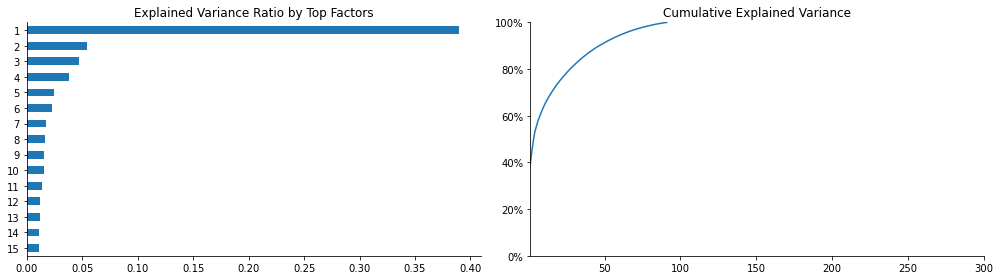

In [15]:
# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1  # align with number of factors
var_expl.iloc[:15].sort_values().plot.barh(title=title, ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [16]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2],
                            columns=['factor1', 'factor2'],
                            index=returns.index)
risk_factors.head()

,factor1,factor2
Date,,
2010-01-08 00:00:00,-0.028907,0.078310
2010-01-15 00:00:00,-0.203827,-0.053479
2010-01-22 00:00:00,-0.240362,-0.023220
2010-01-29 00:00:00,-0.196499,0.021206
2010-02-05 00:00:00,0.157759,-0.094930


In [18]:
# Check that the top two risk factors are uncorrelated (if uncorrelated, then the correlation should be close to zero)
risk_factors['factor1'].corr(risk_factors['factor2'])

2.719978466543054e-14